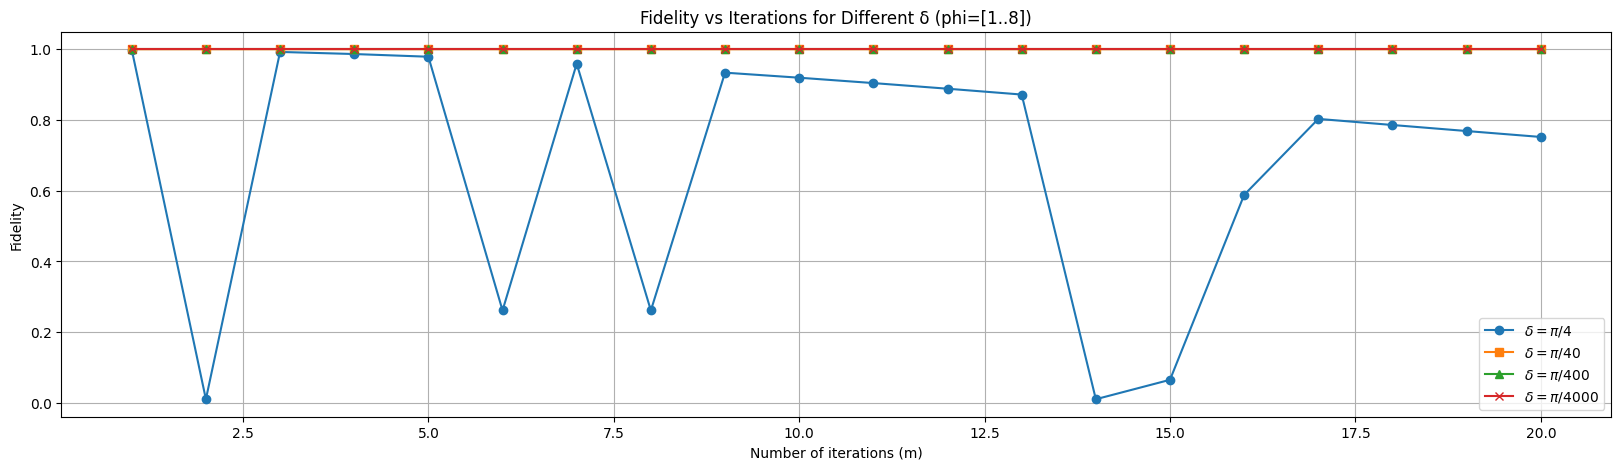

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# --- define psi and phi ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]        # initial psi vector

# Periodic phi using sine
N = 8
f = 2          # number of sine periods over the vector
x = np.arange(N)
phi = np.sin(2 * np.pi * f * x / N)   # φ = sin(2π f j / N)

n = 3                    # number of qubits (log2 of vector length)
number_of_layers = 2     # layers for MPS initialization

# --- create normalized QuantumState objects ---
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

# --- generate MPS initializer circuits ---
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()



# --- protocol function ---
def run_protocol(m, delta, return_state=False):
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    creg = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    # initialize states
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    # iterative protocol
    for k in range(1, m+1):
        # CNOT flags
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # apply small phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # uncompute flags
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute φ, measure, reset
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)

        if k < m:
            qc.append(U_phi, phi_reg)

    # simulate
    sim = AerSimulator()
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # reduced density matrix for ψ
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # Ideal target vector with programmable phase
    psi_vec = np.array(psi) / np.linalg.norm(psi)
    phi_vec = np.array(phi) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    # fidelity
    fid = state_fidelity(rho_psi, rho_ideal)

    if return_state:
        return fid, rho_psi, ideal_vec
    return fid

# --- run for multiple iterations ---
m_values = list(range(1, 21))

# fidelity for different deltas
delta_values = [np.pi/4, np.pi/40, np.pi/400, np.pi/4000]
fidelities_list = []

for delta_val in delta_values:
    fidelities = [run_protocol(m, delta_val) for m in m_values]
    fidelities_list.append(fidelities)

# --- plot fidelity results ---
plt.figure(figsize=(20,5))
labels = [r'$\delta = \pi/4$', r'$\delta = \pi/40$', r'$\delta = \pi/400$', r'$\delta = \pi/4000$']
markers = ['o-', 's-', '^-', 'x-']
for fids, lbl, mk in zip(fidelities_list, labels, markers):
    plt.plot(m_values, fids, mk, label=lbl)
plt.xlabel("Number of iterations (m)")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Iterations for Different δ (phi=[1..8])")
plt.legend()
plt.grid(True)
plt.show()



Example m=20, δ=0.07854: Fidelity=0.999968


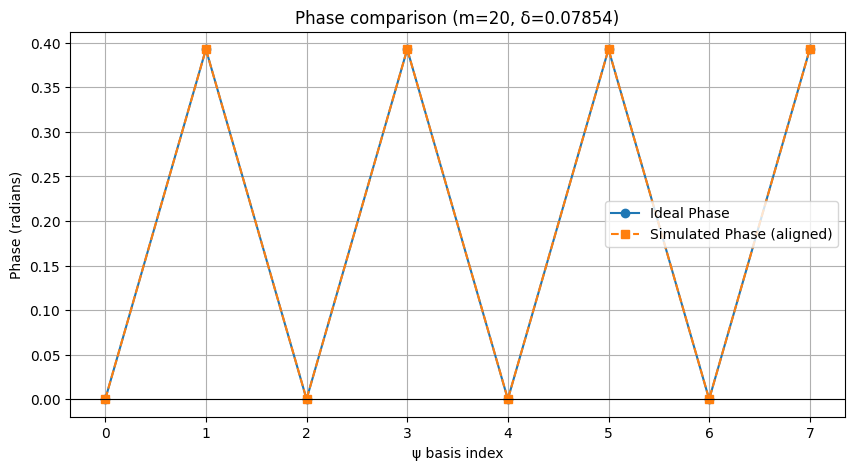

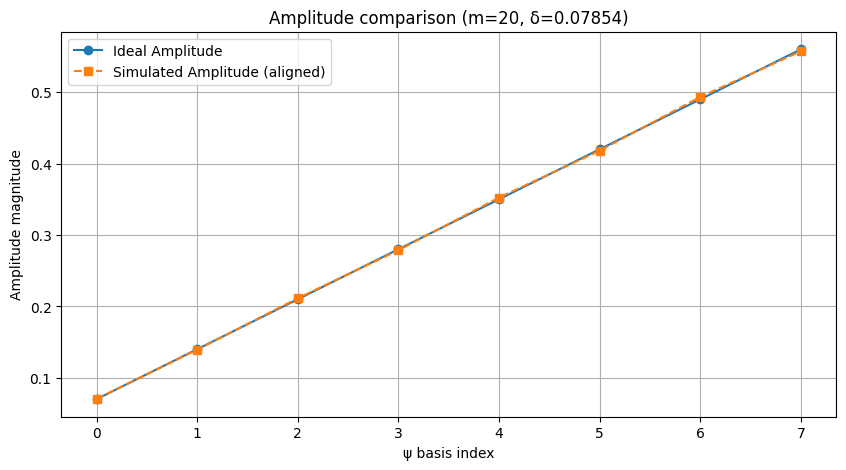

In [ ]:
m_example = 20
delta_example = np.pi/40

fid_ex, rho_psi, ideal_vec = run_protocol(m_example, delta_example, return_state=True)
vec_sim = np.array(rho_psi.to_statevector())

# --- Align global phase ---
global_phase = np.angle(np.vdot(ideal_vec, vec_sim))
vec_sim_aligned = vec_sim * np.exp(-1j * global_phase)

# --- amplitudes and phases ---
amps_ideal = np.abs(ideal_vec)
amps_sim = np.abs(vec_sim_aligned)
phases_ideal = np.unwrap(np.angle(ideal_vec))
phases_sim = np.unwrap(np.angle(vec_sim_aligned))

print(f"Example m={m_example}, δ={delta_example:.5f}: Fidelity={fid_ex:.6f}")

# --- Phase comparison ---
plt.figure(figsize=(10,5))
plt.plot(range(N), phases_ideal, 'o-', label="Ideal Phase")
plt.plot(range(N), phases_sim, 's--', label="Simulated Phase (aligned)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Phase (radians)")
plt.xlabel("ψ basis index")
plt.title(f"Phase comparison (m={m_example}, δ={delta_example:.5f})")
plt.legend()
plt.grid(True)
plt.show()

# --- Amplitude comparison ---
plt.figure(figsize=(10,5))
plt.plot(range(N), amps_ideal, 'o-', label="Ideal Amplitude")
plt.plot(range(N), amps_sim, 's--', label="Simulated Amplitude (aligned)")
plt.ylabel("Amplitude magnitude")
plt.xlabel("ψ basis index")
plt.title(f"Amplitude comparison (m={m_example}, δ={delta_example:.5f})")
plt.legend()
plt.grid(True)
plt.show()